# Calculate the diurnal cycle 

In this notebook, the diurnal cycle of precipitation on local hours on different regions. It is also shows how to create a land sea mask. 

**Functions to take into account** <br>
`attach_coords` attaches coordinates to HEALPix data <br>
`d_cycle` calculate the diurnal cycle. 

### Calling packages

In [2]:
import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import seaborn as sns
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import datashader as ds
import datashader.transfer_functions as tf

from datashader.mpl_ext import dsshow
import cartopy as cartopy

### Defining functions

In [3]:
def get_nest(ds):
    return ds.crs.healpix_order == "nest"

def get_nside(ds):
    return ds.crs.healpix_nside

def attach_coords(ds):
    lons, lats = hp.pix2ang(get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True)
    return ds.assign_coords(
        lat = (("cell",), lats, {"units": "degree_north"}),
        lon = (("cell",), lons, {"units": "degree_east"}),
    )

def read_dataset(catalog,exp_name='ngc3028',zoom=5,time_resolution="P1D"):
    exp = catalog[exp_name](time=time_resolution, zoom=zoom, chunks="auto").to_dask()
    return attach_coords(exp)


In [4]:
def get_domain(var, ds, domain_name):

    domains = {
        "Tropics_ocean": ds[var]
        .where(is_ocean==True)
        .where((ds["lat"] >= -30.1) & (ds["lat"] <= 30),drop=True),
        "Tropics_land": ds[var]
        .where(is_ocean==False)
        .where((ds["lat"] >= -30.1) & (ds["lat"] <= 30),drop=True),
        "s.america": ds[var]
        .where(is_ocean==False)
        .where(((ds["lat"] >= -30.1) & (ds["lat"] <= 10)) & ((ds["lon"] >= 280) & (ds["lon"] <= 330)),drop=True),
        "africa": ds[var]
        .where(is_ocean==False)
        .where(((ds["lat"] >= -30.1) & (ds["lat"] <= 15)) & ((ds["lon"] >= 340) | (ds["lon"] <= 50)),drop=True),
        "M.continent": ds[var]
        .where(is_ocean==False)
        .where(((ds["lat"] >= -10.1) & (ds["lat"] <= 10)) & ((ds["lon"] >= 90) & (ds["lon"] <= 150)),drop=True),
        "M.continent_ocean": ds[var]
        .where(is_ocean==True)
        .where(((ds["lat"] >= -10.1) & (ds["lat"] <= 10)) & ((ds["lon"] >= 90) & (ds["lon"] <= 150)),drop=True)
    }
    return domains[domain_name]

In [5]:
####estimating diurnal cycle of precip
def d_cycle(data):
    lhour = create_local_hour(data)
    dcycle = np.zeros((24,1))
    for t in range(24):
        dcycle[t,0] = data.where(lhour==t).mean(skipna=True)
    return dcycle

def create_local_hour(data):
    lon =  data.lon.where(data.lon<180,data.lon-360)
    lhour1 = (data*0 + data.hour + 24/360*lon).round()
    lhour2 = lhour1.where(lhour1>=0,lhour1+24)
    lhour3 = lhour2.where(lhour2<24,lhour2-24)
    return lhour3

### General settings 

In [6]:
cat = intake.open_catalog("/work/bm1235/k203123/NextGEMS_Cycle3.git/experiments/catalog.yaml")
var = 'pr'
t1,t2 = '2020-12-01','2020-12-31'
sns.set_context('talk')######appereance of plots for talks

In [7]:
#####transform pr units from kg m-2 s-1 to mm d-1
processing_properties = {
    "pr": dict(time_scale=86400),
    "default": dict(time_scale=1),
}

if var == 'pr':
    var_properties = 'pr'
else:
    var_properties = 'default'

### Computing the diurnal cycle of precipitation

In [8]:
%%time
ds_3028 = read_dataset(cat,exp_name='ngc3028',zoom=7,time_resolution="PT30M").sel(
time=slice(t1,t2))

CPU times: user 124 ms, sys: 23 ms, total: 147 ms
Wall time: 246 ms


In [9]:
%%time
ds_3026 = read_dataset(cat,exp_name='ngc3026',zoom=7,time_resolution="PT30M").sel(
time=slice(t1,t2))

CPU times: user 65.5 ms, sys: 2.65 ms, total: 68.1 ms
Wall time: 126 ms


**Compute the land-sea mask** </br>
In this case we compute the land-sea mask based on the same resolution (zoom) of the data, but using the first time step of the daily output. 

In [10]:
####Compute the land-sea mask
is_ocean = np.isfinite(read_dataset(cat,exp_name='ngc3028',zoom=7,time_resolution="P1D").isel(
time=0).atmos_fluxes_heatflux_sensible)

**Diurnal cycle - tropical land**

In [11]:
%%time
domain = 'Tropics_land'
pr_tropics_land = (
    get_domain(var, ds_3028, domain)
    .groupby('time.hour').mean()
    * processing_properties[var_properties]["time_scale"])

CPU times: user 124 ms, sys: 2.32 ms, total: 126 ms
Wall time: 139 ms


In [12]:
%%time
domain = 'Tropics_land'
pr_tropics_land_26 = (
    get_domain(var, ds_3026, domain)
    .groupby('time.hour').mean()
    * processing_properties[var_properties]["time_scale"])

CPU times: user 120 ms, sys: 1.81 ms, total: 122 ms
Wall time: 122 ms


In [13]:
%%time
dcycle_land = d_cycle(pr_tropics_land)

CPU times: user 4min 3s, sys: 49.5 s, total: 4min 52s
Wall time: 24.9 s


In [14]:
%%time
dcycle_land_26 = d_cycle(pr_tropics_land_26)

CPU times: user 4min 23s, sys: 47.7 s, total: 5min 10s
Wall time: 24.6 s


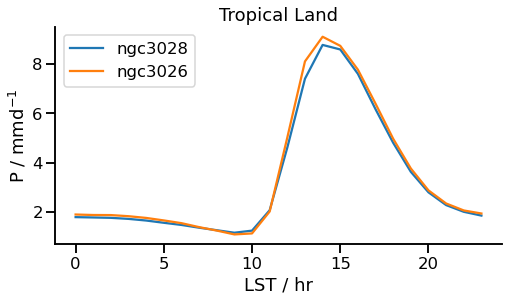

In [15]:
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
ax.plot(dcycle_land,label='ngc3028')
ax.plot(dcycle_land_26,label='ngc3026')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('LST / hr')
ax.set_ylabel('P / mmd$^{-1}$')
ax.set_title('Tropical Land')
plt.legend()

**Diurnal cycle - tropical ocean**

In [16]:
%%time
domain = 'Tropics_ocean'
pr_tropics_ocean = (
    get_domain(var, ds_3028, domain)
    .groupby('time.hour').mean()
    * processing_properties[var_properties]["time_scale"])

CPU times: user 125 ms, sys: 1.99 ms, total: 127 ms
Wall time: 127 ms


In [17]:
%%time
domain = 'Tropics_ocean'
pr_tropics_ocean_26 = (
    get_domain(var, ds_3026, domain)
    .groupby('time.hour').mean()
    * processing_properties[var_properties]["time_scale"])

CPU times: user 124 ms, sys: 1.2 ms, total: 125 ms
Wall time: 125 ms


In [18]:
%%time
dcycle_ocean = d_cycle(pr_tropics_ocean)

CPU times: user 4min 2s, sys: 48.6 s, total: 4min 50s
Wall time: 24.3 s


In [19]:
%%time
dcycle_ocean_26 = d_cycle(pr_tropics_ocean_26)

CPU times: user 4min 8s, sys: 49.6 s, total: 4min 58s
Wall time: 24.2 s


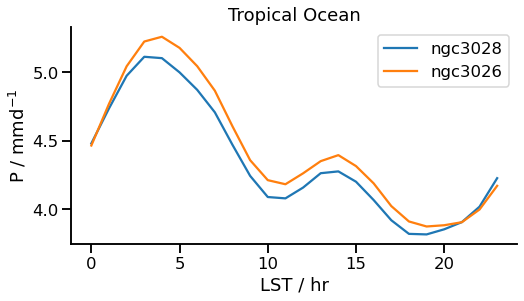

In [20]:
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
ax.plot(dcycle_ocean,label='ngc3028')
ax.plot(dcycle_ocean_26,label='ngc3026')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('LST / hr')
ax.set_ylabel('P / mmd$^{-1}$')
ax.set_title('Tropical Ocean')
plt.legend()